<a href="https://colab.research.google.com/github/Jinzhao-Yu/BioStat615/blob/main/BIOSTAT615_Lecture_8_Fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOSTAT615 Lecture 8 - R

## 1. Recap - Golden section search - Full version

In [1]:
#' Full version of 1-dimensional golden search
#'   Note that there are internal functions defined.
#' @param f - Objective function to minimize
#' @param x0 - initial point to start
#' @param a0 - another initial point (to help find bracket)
#' @param max_iter - maximum iteration
#' @param tol - relative error
#' @return A list containing the following attributes:
#'    * minimum : x-coordinate of minima
#'    * objective : f(minimum)
#'    * convergence : 0 if convergend, 1 otherwise
#'    * iter : number of iterations
#'    * tol : the input tol parameter copied to output 
golden.search.1d <- function(f, x0, a0=NULL, max_iter = 1000, tol=1e-8, ...){
  #' bracket() function
  #' given two starting points, find intervals to bracket
  bracket <- function(f, a0, b0, scale=1.618, max_iter=1000,...){
    fa <- f(a0,...)
    fb <- f(b0,...)
    if(fa < fb){  ## ensure f(a) > f(b)
      temp = b0; b0 = a0; a0 = temp
      temp = fb; fb = fa; fa = temp
    }
    c0 <- b0 + scale*(b0 - a0)  ## find a new point
    fc <- f(c0,...)
    iter = 1
    convergence = 0
    while(fb > fc | fb > fa){   ## if f(b) is not smallest, keep searching
      a0 <- b0; fa <- fb        ## assign (b0, c0) to new (a0, b0) 
      b0 <- c0; fb <- fc        
      c0 <- b0 + scale*(b0 - a0) ## and find the new c0
      fc <- f(c0,...)           ## evaluate the function
      if( (iter > max_iter) || is.infinite(fc) || is.infinite(c0 )) { 
        convergence = 1
        break
      }
      iter = iter+1
    }
    return(list(intervals=c(a0,b0,c0),f_intervals=c(fa,fb,fc),
                iter=iter,convergence=convergence))
  }

  #' golden.step() function
  #' identify the next x-cooridnate to evaluate
  golden.step <- function(a0,b0,c0,gold=0.38196){
    mid = (a0+c0)*0.5
    if(b0 > mid){
      return(gold*(a0-b0))
    } else {
      return(gold*(c0-b0))
    }
  }
  
  # initialization find the initial value to start
  if(is.null(a0)){
    a0 = x0 - 100
  }
  initial <- bracket(f,a0,x0,...) ## bracket
  if(initial$convergence==1){
    stop("Fail to find good initial values!")
  }
  a0 = initial$intervals[1]
  b0 = initial$intervals[2]
  c0 = initial$intervals[3]

  #########################################
  ## the main part of golden-section search  
  #########################################
  fb = f(b0,...)
  iter = 0
  convergence = 1
  while(iter < max_iter){
    x <- b0 + golden.step(a0,b0,c0) ## find the new x point to evaluate
    fx <- f(x,...)
    if(fx < fb){   ## if x is a new minima, keep (b0, x, c0) or (a0, x, b0)
      if(x > b0) a0 = b0 else c0 = b0
      b0 = x; fb = fx
    } else{        ## if b0 is still minima, keep (x, b0, c0) or (a0, b0, x) 
      if(x < b0) a0 = x else c0 = x
    }
    iter = iter + 1
    if(abs(c0-a0) < abs(b0)*tol){ ## check convergence
      convergence = 0
      break
    }
  }
  return(list(minimum=b0,objective=fb,convergence=convergence,
              iter=iter,tol=tol))
}

## 2. Multi-dimensional coordinate Descent

In [2]:
#' Multi-dimensional coordinate descent
#' @param f - Objective function to minimize
#' @param x0 - initial point to start
#' @param tol - relative error
#' @param max_iter - maximum iteration
#' @return A list containing the following attributes:
#'    * xmin : x-coordinate of minima
#'    * fmin : f(xmin)
#'    * convergence : 0 if convergend, 1 otherwise
#'    * iter : number of iterations
coordinate.descent <- function(f, x0, tol = 1e-10, max_iter = 5000,...){
  d = length(x0)  ## d is input dimension
  convergence = 1
  x1 <- x0
  f0 <- f(x0,...) ## evaluate f0
  for(iter in 1:max_iter){  ## repeat iterations
    for(i in 1:d){          ## select each coordinate
      f_i <- function(x_i){ ## f_i() is 1-d function for i-th coordinate
        xk = x1
        xk[i] <- x_i
        f(xk,...)
      }
      res_i <- golden.search.1d(f_i,x1[i]) ## perform golden search
      if(res_i$convergence==0){
        x1[i] <- res_i$minimum 
      } else{
        stop(paste("It does not converge at iteration ", iter ,"for udpating the",
                   i,"th component!"))
      }
    }
    f1 <- res_i$objective
    if(abs(f1-f0) <= tol*(abs(f1)+abs(f0))){ ## check convergence
      convergence = 0
      break
    } else{ 
      x0 <- x1
      f0 <- f1
    }
  }  
  return(list(xmin=x1,fmin=f1,convergence=convergence,iter=iter))
}


## 3. Nelder-Mead algorithm

In [3]:
#' Multi-dimensional Nelder-Mead
#' @param f - Objective function to minimize
#' @param x0 - initial point to start
#' @param tol - relative error
#' @param max_iter - maximum iteration
#' @return A list containing the following attributes:
#'    * xmin : x-coordinate of minima
#'    * fmin : f(xmin)
#'    * convergence : 0 if convergend, 1 otherwise
#'    * iter : number of iterations 
Nelder.Mead <- function(f, x0, tol = 1e-10, max_iter = 1000,...){
  d <- length(x0)   # d:dimension of the simplex  
  X <- matrix(x0,nrow=d,ncol=d+1)    # set d+1 simplex points
  X[,-(d+1)] <- X[,-(d+1)] + diag(d) # create a simplex 
  Y <- apply(X,2,f,...)   # evaluate function at each vertex
  
  ## initialize key variables as NULL
  idx_max <- NULL; idx_min <- NULL; idx_2ndmax <- NULL ## extremes
  mid_point <- NULL; tru_line <- NULL ## mid-point and tru-line
  
  ## Function to update the extremes 
  update.extremes <- function(){
    if(Y[1] > Y[2]){
      idx_max <<- 1; idx_min <<- 2; idx_2ndmax <<- 2 ## note: global assignment
    } else{
      idx_max <<- 2; idx_2ndmax <<- 1; idx_min <<- 1 ## note: global assignment
    }
    if(d>1){
      for(i in 3:(d+1)){
        if(Y[i] <= Y[idx_min]){
          idx_min <<- i
        } else if(Y[i] > Y[idx_max]){
          idx_2ndmax <<- idx_max; idx_max <<- i
        } else if(Y[i] > Y[idx_2ndmax]){
          idx_2ndmax <<- i
        }
      } 
    }
  }
  
  ## Function to update the mid-point and the tru-line 
  update.mid.point <- function(){
    mid_point <<- apply(X[,-idx_max,drop=FALSE],1,mean)
    tru_line <<- X[,idx_max] - mid_point
  }
  
  ## Function update the next point (reflection, expansion, contraction)
  update.next.point <- function(step_scale){
    next_point <- mid_point + tru_line*step_scale
    Y_next <- f(next_point,...)
    if(Y_next < Y[idx_max]){
      X[,idx_max] <<- next_point
      Y[idx_max] <<- Y_next
      return(TRUE)
    } else{
      return(FALSE)
    }
  }
  
  ## Function for multiple contaction 
  contract.simplex <- function(){
    X[,-idx_min] <<- 0.5*(X[,-idx_min] + X[,idx_min])
    Y[-idx_min] <<- apply(X[,-idx_min],2,f,...)
  }

  #########################################
  ## the main part of Nelder-Mead algorithm  
  #########################################
  convergence = 1
  for(iter in 1:max_iter){
    update.extremes()  ## update idx_min, idx_max, idx_2ndmax
    if(abs(Y[idx_max]-Y[idx_min]) <= tol*(abs(Y[idx_max]) + abs(Y[idx_min]) +tol)){
      convergence = 0
      break
    } ## check convergence
    update.mid.point() ## update mid-point, tru-line
    
    update.next.point(-1.0)   ## reflection
    if(Y[idx_max] < Y[idx_min]){
      update.next.point(-2.0) ## expansion
    } else if(Y[idx_max] >= Y[idx_2ndmax]){
      if(!update.next.point(0.5)){  ## perform 1-d contraction
        contract.simplex()    ## multiple contraction
      }
    }
  }
  return(list(xmin=X[,idx_min],fmin=Y[idx_min],convergence=convergence,iter=iter))
}


## 4. Gradient Descent

In [4]:
#' Multi-dimensional Gradient Descent
#' @param f - Objective function to minimize
#' @param g - Gradient vector for f
#' @param x0 - initial point to start
#' @param step_size - step size to update parameters
#' @param update_step_size - allow updating step size using line search
#' @param tol - relative error
#' @param max_iter - maximum iteration
#' @return A list containing the following attributes:
#'    * xmin : x-coordinate of minima
#'    * fmin : f(xmin)
#'    * step_size : step_size used for each iteration
#'    * convergence : 0 if convergend, 1 otherwise
#'    * iter : number of iterations 
gradient.descent <- function(f, g, x0,step_size=0.0001,update_step_size = TRUE,
                             tol=1e-10, max_iter=5000,...){
  f0 <- f(x0,...)
  g0 <- g(x0,...)
  convergence = 1
  for(iter in 1:max_iter){
    x1 <- x0 - step_size*g0 ## x1 is the next point to evaluate
    f1 <- f(x1,...)  ## note that you can pass through additional parameters
    g1 <- g(x1,...)
    if(is.infinite(f1)){
      stop("It does not converge, try different initial values 
           or a smaller step size or updating the step size!")
    }
    if(abs(f1-f0)<=tol*(abs(f1)+abs(f0))){
      convergence = 0
      break
    } else{
      if(update_step_size){ ## apply the algorithm to update step_size if requested
        step_size = abs(sum((x1 - x0)*(g1-g0)))/sum((g1-g0)^2)
      }
      x0 <- x1
      f0 <- f1
      g0 <- g1
    }
  }
  return(list(xmin=x1,fmin=f1,step_size = step_size,
              convergence=convergence,iter=iter))
}


## 5. Newton's method

In [5]:
#' Multi-dimensional Newton's method to minimize
#' @param f - Objective function to minimize
#' @param g - Gradient vector for f
#' @param h - Hessian matrix for f
#' @param x0 - initial point to start
#' @param tol - relative error
#' @param max_iter - maximum iteration
#' @return A list containing the following attributes:
#'    * xmin : x-coordinate of minima
#'    * fmin : f(xmin)
#'    * f_deriv : f'(xmin) - a vector
#'    * Hessian : f''(xmin) - a Hessian matrix
#'    * convergence : 0 if convergend, 1 otherwise
#'    * iter : number of iterations 
Newton.method <- function(f,g,h,x0,tol=1e-10,max_iter=5000,...){
  f0 <- f(x0,...)
  g0 <- g(x0,...)
  h0 <- h(x0,...)
  convergence = 1
  d = length(x0)
  for(iter in 1:max_iter){
    x1 <- x0 - solve(matrix(h0,nrow=d,ncol=d),g0) ## determine x1 based on g0, h0
    f1 <- f(x1,...)    ## evaluate new function value
    if(is.infinite(f1)){
      stop("It does not converge,try different initial values!")
    }
    g1 <- g(x1,...)
    h1 <- h(x1,...)
    if(abs(f1-f0)<=tol*(abs(f1)+abs(f0))){
      convergence = 0
      break
    } else{    ## update the parameters
      x0 <- x1
      f0 <- f1
      g0 <- g1
      h0 <- h1
    }
  }
  return(list(xmin=x1,fmin=f1, f_deriv = g1, Hessian = matrix(h1,nrow=d,ncol=d),
              convergence=convergence,iter=iter))
}


## 6. Utilizing optimization functions built-in R

Let's evaluate minimization algorithms with

$$
f_1(x_1,x_2) = 100(x_2-x_1^2)^2 + (1-x_1)^2 
$$

which has clearly global minima at $(1,1)$ 

In [6]:
fn = function(x) return(100*(x[2]-x[1]^2)^2 + (1-x[1])^2) 

We can use Nelder-Mead algorithm implemented in `optim()` function

In [7]:
results = optim(par=c(-1.3,1.1),fn=fn,method="Nelder-Mead")
print(results)

$par
[1] 1.000063 1.000112

$value
[1] 2.165884e-08

$counts
function gradient 
     165       NA 

$convergence
[1] 0

$message
NULL



Or the Nelder-Mead algorithm we implemented above

In [8]:
results = Nelder.Mead(fn, c(-1.3,1.1))
print(results)

$xmin
[1] 1 1

$fmin
[1] 4.446283e-22

$convergence
[1] 0

$iter
[1] 139



Do you see a difference between the two?

## 7. More evaluations of optimization functions

Let's consider minimizing these three functions 
\begin{eqnarray*}
f_1(x_1,x_2) & = & 100(x_2-x_1^2)^2 + (1-x_1)^2 \\
f_2(x_1,x_2,x_3) & = & x_1x_2+x_2x_3 + x_1x_3 + (x_1-1)^2 + (x_2-1)^2 + (x_3-1)^2\\
f_3(x_1,x_2) & = & \sin(0.5x_1^2-0.5x_2^2+3)\cos(2x_1+1-e^{x_2})
\end{eqnarray*}

It is clear that $f_1$ is minimized at $(1,1)$.

With some calculations, you will be able to find $f_2$ is minimized at $(0.5, 0.5, 0.5)$. 

It may be hard to find the exact lower bound of $f_3$, but it is clear that it should be -1 or greater.

In [9]:
## define f1, f2, f3 as above
f1 <- function(x1,x2){
  100 * (x2 - x1 * x1)^2 + (1 - x1)^2
}

f2 <- function(x1,x2,x3){
  x1*x2+x2*x3+x1*x3+(x1-1.0)^2+(x2-1.0)^2+(x3-1.0)^2
}

f3 <- function(x1,x2){
  sin(0.5*x1^2-0.5*x2^2+3)*cos(2*x1+1 - exp(x2))
}

In [10]:
## we also define f1_multi, f2_multi, f3_multi
## that takes a vector of x as the parameter 
f1_multi <- function(x) {   
  f1(x[1],x[2])
}

f2_multi <- function(x){
  f2(x[1],x[2],x[3])
}

f3_multi <- function(x){
  f3(x[1],x[2])
}

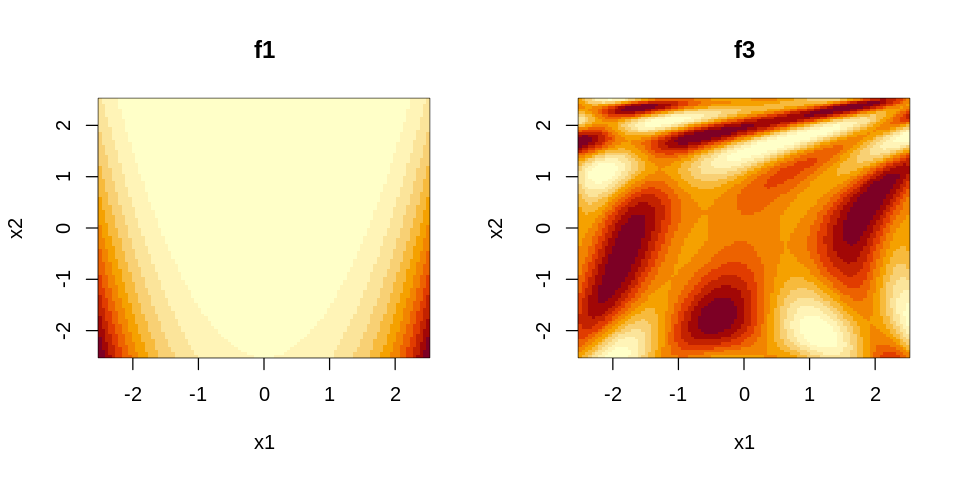

In [11]:
# Visualize f1 and f3
options(repr.plot.width=8, repr.plot.height=4)
x1<-seq(-2.5,2.5,length=100)
x2<-seq(-2.5,2.5,length=100)
z1<-apply(expand.grid(x1,x2),1,f1_multi)
z3<-apply(expand.grid(x1,x2),1,f3_multi)
par(mfcol=c(1,2))
image(x1,x2,matrix(z1,nrow=100,ncol=100),main=paste("f1"))
image(x1,x2,matrix(z3,nrow=100,ncol=100),main=paste("f3"))

In [12]:
## coordinate descent
system.time(CD1<-coordinate.descent(f1_multi,c(-10,-10),tol=1e-7))
system.time(CD2<-coordinate.descent(f2_multi,c(10,10,10),tol=1e-7))
system.time(CD3<-coordinate.descent(f3_multi,c(-0.5,-3),tol=1e-7))

   user  system elapsed 
  2.259   0.004   2.271 

   user  system elapsed 
  0.019   0.000   0.019 

   user  system elapsed 
  0.095   0.000   0.095 

In [13]:
## print the output from coordinate descent algorithm
print(CD1)
cat("------------------\n")
print(CD2)
cat("------------------\n")
print(CD3)

$xmin
[1] 0.9999983 0.9999966

$fmin
[1] 2.850277e-12

$convergence
[1] 0

$iter
[1] 4695

------------------
$xmin
[1] 0.4998471 0.5002165 0.4999682

$fmin
[1] 1.5

$convergence
[1] 0

$iter
[1] 11

------------------
$xmin
[1] 23.092009 -2.882981

$fmin
[1] -0.9999913

$convergence
[1] 0

$iter
[1] 206



In [14]:
## Nelder-Mead
system.time(NM1<-Nelder.Mead(f1_multi,c(-10,-10),tol=1e-7))
system.time(NM2<-Nelder.Mead(f2_multi,c(10,10,10),tol=1e-7))
system.time(NM3<-Nelder.Mead(f3_multi,c(-0.5,-3),tol=1e-7))

   user  system elapsed 
  0.004   0.001   0.005 

   user  system elapsed 
  0.005   0.000   0.004 

   user  system elapsed 
  0.001   0.000   0.002 

In [15]:
## print the output from Nelder-Mead algorithm algorithm
print(NM1)
cat("------------------\n")
print(NM2)
cat("------------------\n")
print(NM3)

$xmin
[1] 1 1

$fmin
[1] 3.385724e-14

$convergence
[1] 0

$iter
[1] 118

------------------
$xmin
[1] 0.4999766 0.5000795 0.5002467

$fmin
[1] 1.5

$convergence
[1] 0

$iter
[1] 91

------------------
$xmin
[1] -0.4767809 -3.0608912

$fmin
[1] -0.9999999

$convergence
[1] 0

$iter
[1] 32



In [16]:
## Nelder-Mead in optim()
system.time(ONM1<-optim(par=c(-10,-10),fn=f1_multi,method="Nelder-Mead"))
system.time(ONM2<-optim(par=c(10,10,10),fn=f2_multi,method="Nelder-Mead"))
system.time(ONM3<-optim(par=c(-0.5,-3),fn=f3_multi,method="Nelder-Mead"))

   user  system elapsed 
  0.001   0.000   0.000 

   user  system elapsed 
  0.001   0.000   0.000 

   user  system elapsed 
      0       0       0 

In [17]:
## print the output from Nelder-Mead algorithm using optim()
print(ONM1)
cat("------------------\n")
print(ONM2)
cat("------------------\n")
print(ONM3)

$par
[1] 0.4425542 0.1711704

$value
[1] 0.3716748

$counts
function gradient 
      93       NA 

$convergence
[1] 0

$message
NULL

------------------
$par
[1] 0.4961880 0.4993082 0.5007724

$value
[1] 1.500015

$counts
function gradient 
     126       NA 

$convergence
[1] 0

$message
NULL

------------------
$par
[1] -0.4765989 -3.0608350

$value
[1] -1

$counts
function gradient 
      59       NA 

$convergence
[1] 0

$message
NULL



Do you see the difference between Nelder-Mead implementations? Which one is better?

Now, let's look at the gradient-based optimization algorithms. We need to take the derivative of these functions, but `Deriv` package makes our lives easier.

In [18]:
# gradient based optimization
install.packages("Deriv")
library(Deriv)

# Deriv() performs symbolic differentiation 
g1 = Deriv(f1)
g2 = Deriv(f2)
g3 = Deriv(f3)

# Deriv() can also calculates Hessian too.
h1 = Deriv(f1,nderiv=2)
h2 = Deriv(f2,nderiv=2)
h3 = Deriv(f3,nderiv=2)

# convert gradients into single-parameter functions
g1_multi <- function(x){
   g1(x[1],x[2])
}
g2_multi <- function(x){
  g2(x[1],x[2],x[3])
}
g3_multi <- function(x){
  g3(x[1],x[2])
}

# convert Hessians into single parameter functions
h1_multi <- function(x){
  h1(x[1],x[2])
}
h2_multi <- function(x){
  h2(x[1],x[2],x[3])
}
h3_multi <- function(x){
  h3(x[1],x[2])
}


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [19]:
## Apply gradient descent algorithms
system.time(GD1<-gradient.descent(f1_multi,g1_multi,c(-10,-10),step_size=0.00001,
                                  update_step_size = TRUE,tol=1e-7))
system.time(GD2<-gradient.descent(f2_multi,g2_multi,c(10,10,10),step_size=0.001,
                                  update_step_size = TRUE,
                                  tol=1e-7))
system.time(GD3<-gradient.descent(f3_multi,g3_multi,c(1,1),step_size=0.00001,
                                  update_step_size = TRUE,
                                  tol=1e-7))

   user  system elapsed 
  0.028   0.000   0.028 

   user  system elapsed 
  0.011   0.000   0.012 

   user  system elapsed 
  0.014   0.001   0.015 

In [20]:
## Print the output of gradient descent algorithms
print(GD1)
cat("------------------\n")
print(GD2)
cat("------------------\n")
print(GD3)

$xmin
x1 x2 
 1  1 

$fmin
          x2 
1.232595e-32 

$step_size
[1] 0.0009984019

$convergence
[1] 0

$iter
[1] 64

------------------
$xmin
 x1  x2  x3 
0.5 0.5 0.5 

$fmin
 x1 
1.5 

$step_size
[1] 0.25

$convergence
[1] 0

$iter
[1] 3

------------------
$xmin
      x1       x2 
3.492352 1.577550 

$fmin
x1 
-1 

$step_size
[1] 0.02704127

$convergence
[1] 0

$iter
[1] 30



In [21]:
## Apply Newton's method
system.time(ND1<-Newton.method(f1_multi,g1_multi,h1_multi,c(-10,-10),tol=1e-7))
system.time(ND2<-Newton.method(f2_multi,g2_multi,h2_multi,c(10,10,10),tol=1e-7))
system.time(ND3<-Newton.method(f3_multi,g3_multi,h3_multi,c(1,1),tol=1e-7))

   user  system elapsed 
  0.022   0.004   0.037 

   user  system elapsed 
  0.004   0.000   0.004 

   user  system elapsed 
  0.032   0.000   0.032 

In [22]:
## Examine the output from Newton's method
print(ND1)
cat("------------------\n")
print(ND2)
cat("------------------\n")
print(ND3)

$xmin
[1] 1 1

$fmin
[1] 0

$f_deriv
x1 x2 
 0  0 

$Hessian
     [,1] [,2]
[1,]  802 -400
[2,] -400  200

$convergence
[1] 0

$iter
[1] 6

------------------
$xmin
[1] 0.5 0.5 0.5

$fmin
[1] 1.5

$f_deriv
x1 x2 x3 
 0  0  0 

$Hessian
     [,1] [,2] [,3]
[1,]    2    1    1
[2,]    1    2    1
[3,]    1    1    2

$convergence
[1] 0

$iter
[1] 2

------------------
$xmin
[1] -2.539389e-15  8.474887e-15

$fmin
[1] 0.14112

$f_deriv
          x1           x2 
6.336838e-15 6.478643e-15 

$Hessian
          [,1]      [,2]
[1,] -1.554473 0.2822400
[2,]  0.282240 0.8488725

$convergence
[1] 0

$iter
[1] 4



In [23]:
## L-BFGS in optim()
system.time(LBB1<-optim(par=c(-10,-10),fn=f1_multi,gr=g1_multi,method="L-BFGS-B"))
system.time(LBB2<-optim(par=c(10,10,10),fn=f2_multi,gr=g2_multi,method="L-BFGS-B"))
system.time(LBB3<-optim(par=c(-0.5,-3),fn=f3_multi,gr=g3_multi,method="L-BFGS-B"))

   user  system elapsed 
  0.001   0.000   0.000 

   user  system elapsed 
      0       0       0 

   user  system elapsed 
  0.001   0.000   0.000 

In [24]:
## Examine the results from L-BGFS
print(LBB1)
cat("------------------\n")
print(LBB2)
cat("------------------\n")
print(LBB3)

$par
[1] 1 1

$value
[1] 7.523157e-15

$counts
function gradient 
      31       31 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

------------------
$par
[1] 0.5 0.5 0.5

$value
[1] 1.5

$counts
function gradient 
       5        5 

$convergence
[1] 0

$message
[1] "CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL"

------------------
$par
[1] -0.4765756 -3.0608358

$value
[1] -1

$counts
function gradient 
       8        8 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

